In [130]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

import torch, config
import IPDL
from autoencoder import SDAE, SDAE_TYPE, AE_CONV_UPSAMPLING
import numpy as np

In [131]:
from DFU import DiabeticFootDataset
# Diabetic Foot Dataset
    # Training dataset
DATASET_DIR = "/home/abian/Data/Dataset/DiabeticFootDataset/"
iactec_dataset_dir = os.path.join(DATASET_DIR, 'IACTEC/Processed/Cropped')
inaoe_dataset_dir = os.path.join(DATASET_DIR, 'INAOE/Processed/Cropped')
_dataset = DiabeticFootDataset([iactec_dataset_dir, inaoe_dataset_dir])

    # Testing dataset
test_dataset_dir = os.path.join(DATASET_DIR, 'Test/Processed/Cropped')
_test_set = DiabeticFootDataset(test_dataset_dir)

from DFU import DiabeticFootTorchDataset
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
from torch.utils.data import DataLoader

# transforms = Compose([Resize((64, 64)), ToTensor()])
transform = Compose([Resize((64, 64)), ToTensor(), Normalize([0.5], [0.5])])

#train
train_set = DiabeticFootTorchDataset(_dataset, transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

#test
test_set = DiabeticFootTorchDataset(_test_set, transform=transform)
val_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [132]:
# from torchvision import datasets
# from torchvision.transforms import ToTensor, Resize, Compose, Normalize

# transforms = Compose([
#     Resize((64,64)),
#     ToTensor(),
#     Normalize([0.5], [0.5])
# ])

# # train_set = datasets.FashionMNIST("dataset", train=True, download=True, transform=transforms)
# test_set = datasets.FashionMNIST("dataset", train=False, download=True, transform=transforms)

# from torch.utils.data import DataLoader
# # train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
# val_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [133]:
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as MRE
from IPDL.InformationTheory import TensorKernel
from IPDL import MatrixEstimator
from torch import nn
import pandas as pd

def conv_mi(module: nn.Module):
    matrix_estimator = None
    for i in module:
        print(i)
        if isinstance(i, MatrixEstimator):
            matrix_estimator = i
            break
    
    if matrix_estimator is None:
        return
    
    x = matrix_estimator.x
    n = x.size(0)
    sigma = matrix_estimator.sigma.data
    mi_matrix = np.zeros((x.size(1), x.size(1)))

    for ref_idx in range(x.size(1)):
        ref_filter = x[:, ref_idx, :]
        Ax = TensorKernel.RBF(ref_filter.flatten(1), sigma) / n

        for comp_idx in range(x.size(1)):
            if ref_idx == comp_idx:
                mi_matrix[ref_idx, comp_idx] = MRE.entropy(Ax)
            else:
                comp_filter = x[:, comp_idx, :]
                Ay = TensorKernel.RBF(comp_filter.flatten(1), sigma) / n
                mi_matrix[ref_idx, comp_idx] = MRE.mutualInformation(Ax, Ay)

    n_filters = x.size(1)
    index = ["F{}".format(i+1) for i in range(n_filters)]
    df = pd.DataFrame(mi_matrix, index = index, columns = index)
    
    return df

In [134]:
from functools import reduce
from IPDL.optim.func import silverman_optimize
from IPDL.functional import matrix_estimator
def get_Ax(x, gamma=.5):
    n = x.size(0)
    d = x.size(1) if len(x.shape)==2 else reduce(lambda x,y:x*y, x.shape[1:])

    sigma = silverman_optimize(x, gamma=gamma, normalize=True)
    print(sigma)
    _, Ax = matrix_estimator(x, sigma)
    return Ax

In [135]:
val_inputs = next(iter(val_loader))[0]
gamma = 4e-1
Ax = get_Ax(val_inputs, gamma=gamma)
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as MRE

print("Input Entropy: {}".format(MRE.entropy(Ax)))

25.578369426608894
Input Entropy: 2.8131275177001953


In [136]:
from torch import nn

activation_func = [[nn.ReLU(), nn.Identity()], nn.ReLU(), nn.ReLU()]
ae_dropout_p5 = {'dims': [1, 6, 8, 16],
                'sdae_type': SDAE_TYPE.conv,
                'activation_func': activation_func,
                'dropout': True,
                'p': .5,
                'skip_connection': False,
                'upsample': AE_CONV_UPSAMPLING.up_layer}

ae_dropout_p2 = {'dims': [1, 6, 8, 16],
                'sdae_type': SDAE_TYPE.conv,
                'activation_func': activation_func,
                'dropout': True,
                'p': .2,
                'skip_connection': False,
                'upsample': AE_CONV_UPSAMPLING.up_layer}

ae_no_dropout = {'dims': [1, 6, 8, 16],
                'sdae_type': SDAE_TYPE.conv,
                'activation_func': activation_func,
                'dropout': False,
                'skip_connection': False,
                'upsample': AE_CONV_UPSAMPLING.up_layer}

In [137]:
model_name='ae_dropout_p5'
model = SDAE(**ae_dropout_p5)

model_name='ae_dropout_p2'
model = SDAE(**ae_dropout_p2)

model_name='ae_no_dropout'
model = SDAE(**ae_no_dropout)



model.load_state_dict(torch.load('models/{}/AE_FMNIST.pt'.format(model_name)))

<All keys matched successfully>

In [138]:
model.eval()
_ = model(val_inputs)

In [139]:
df = []
for layer_idx, layer in enumerate(model.encode):
    df.append( conv_mi(layer) )
    # if isinstance(layer, MatrixEstimator):
    #     print("Layer: {}".format(layer_idx))
    #     print(conv_mi(layer))

Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
MatrixEstimator(sigma=31.33, requires_optim=True)
Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
MatrixEstimator(sigma=18.06, requires_optim=True)
Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
MatrixEstimator(sigma=12.74, requires_optim=True)


In [140]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib

def show_convolutional_filters_mi(df: pd.DataFrame, subspace_label: str):
        r"""
            Heatmap for Mutual Information among convolutional filters in a layer.

            Args
            ----
                df (pandas.DataFrame): Dataframe which contains the MI among filters.

                subspace_label (str): Label which describres the subspace in the layer.
        """
        data = df.to_numpy()
        value_fontsize = 24 if len(df) < 10 else 16
        filter_fontsize = 32 if len(df) < 10 else 24

        # cmap = plt.cm.get_cmap('Purples')
        cmap = matplotlib.colormaps['Purples']
        fig = plt.figure(constrained_layout=False, figsize=(12,12))
        gs = fig.add_gridspec(nrows=df.columns.size, ncols=1, left=0.05, right=0.94, hspace=-.05)
        gs_2 = fig.add_gridspec(nrows=1, ncols=1, left=0.94, right=0.98)

        filters = list(map(lambda x: '$F_{%s}^{%d}$' % (subspace_label, x+1), range(df.columns.size)))

        for i in range(df.columns.size):
            heatmap_ax = fig.add_subplot(gs[i, 0])
            heatmap_ax.imshow(data[i,:].reshape(1,-1), cmap=cmap)
            heatmap_ax.set_xticks([])
            heatmap_ax.set_yticks([0])
            heatmap_ax.set_yticklabels([filters[i]], rotation=45, fontsize=filter_fontsize)
            heatmap_ax.spines["top"].set_visible(False)        
            heatmap_ax.spines["bottom"].set_visible(False)

            if i == df.columns.size -1:
                heatmap_ax.set_xticks(np.arange(df.columns.size))
                heatmap_ax.set_xticklabels(filters, rotation=45, fontsize=filter_fontsize)
                heatmap_ax.spines["bottom"].set_visible(True)
            elif i == 0:
                heatmap_ax.spines["top"].set_visible(True)

            reference = data[i,i]
            for idx, value in enumerate(data[i,:]):
                color = 'white' if value > reference*.9 else 'black'
                heatmap_ax.text(idx, 0, "{:.2f}".format(value), color=color, ha='center', va='center', fontsize=value_fontsize)

        colorbar_ax = fig.add_subplot(gs_2[:])
        cb = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=cmap, orientation='vertical')
        cb.set_ticks([0.1,.99])
        colorbar_ax.tick_params(axis='y', which='major', pad=45)
        colorbar_ax.tick_params(axis='both', which='major', length=0)

        cb.set_label('$\mathcal{I}(F_{%s}^i;F_{%s}^j)$' % (subspace_label, subspace_label), labelpad=-25, fontsize=28)
        colorbar_ax.set_yticklabels(['$\mathcal{I}(F_{%s}^i;F_{%s}^j)_{Min}$' % (subspace_label, subspace_label), '$\mathcal{H}(F_{%s}^i)$' % (subspace_label)], 
                                    fontsize=26, rotation=90, ha='right')

        return fig

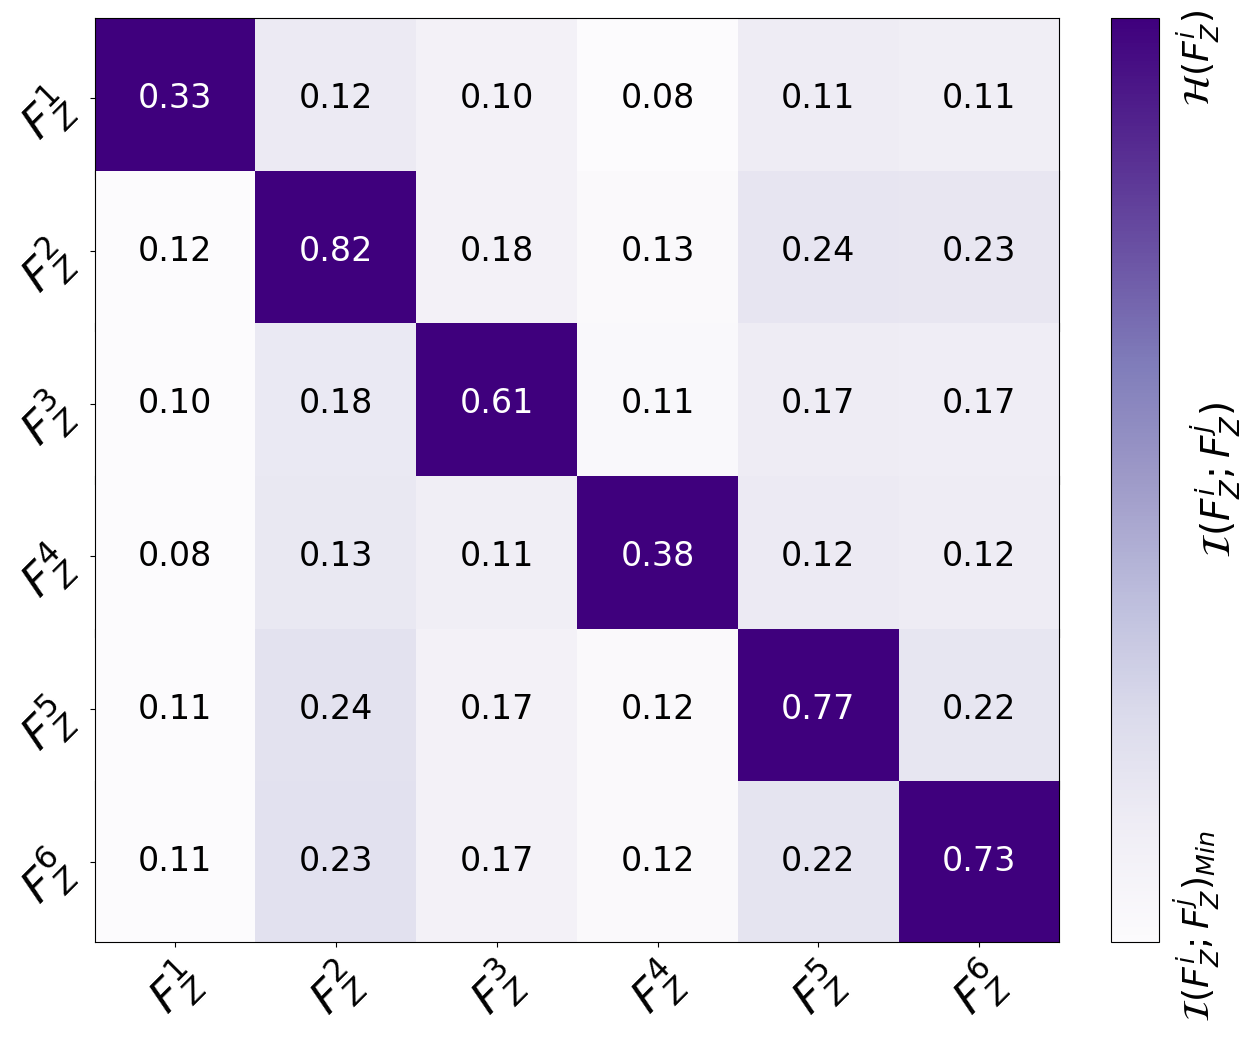

In [141]:
show_convolutional_filters_mi(df[0], 'Z')
plt.show()

Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout2d(p=0.5, inplace=False)
MatrixEstimator(sigma=31.33, requires_optim=True)
Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout2d(p=0.5, inplace=False)
MatrixEstimator(sigma=18.06, requires_optim=True)
Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout2d(p=0.5, inplace=False)
MatrixEstimator(sigma=12.74, requires_optim=True)
Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(

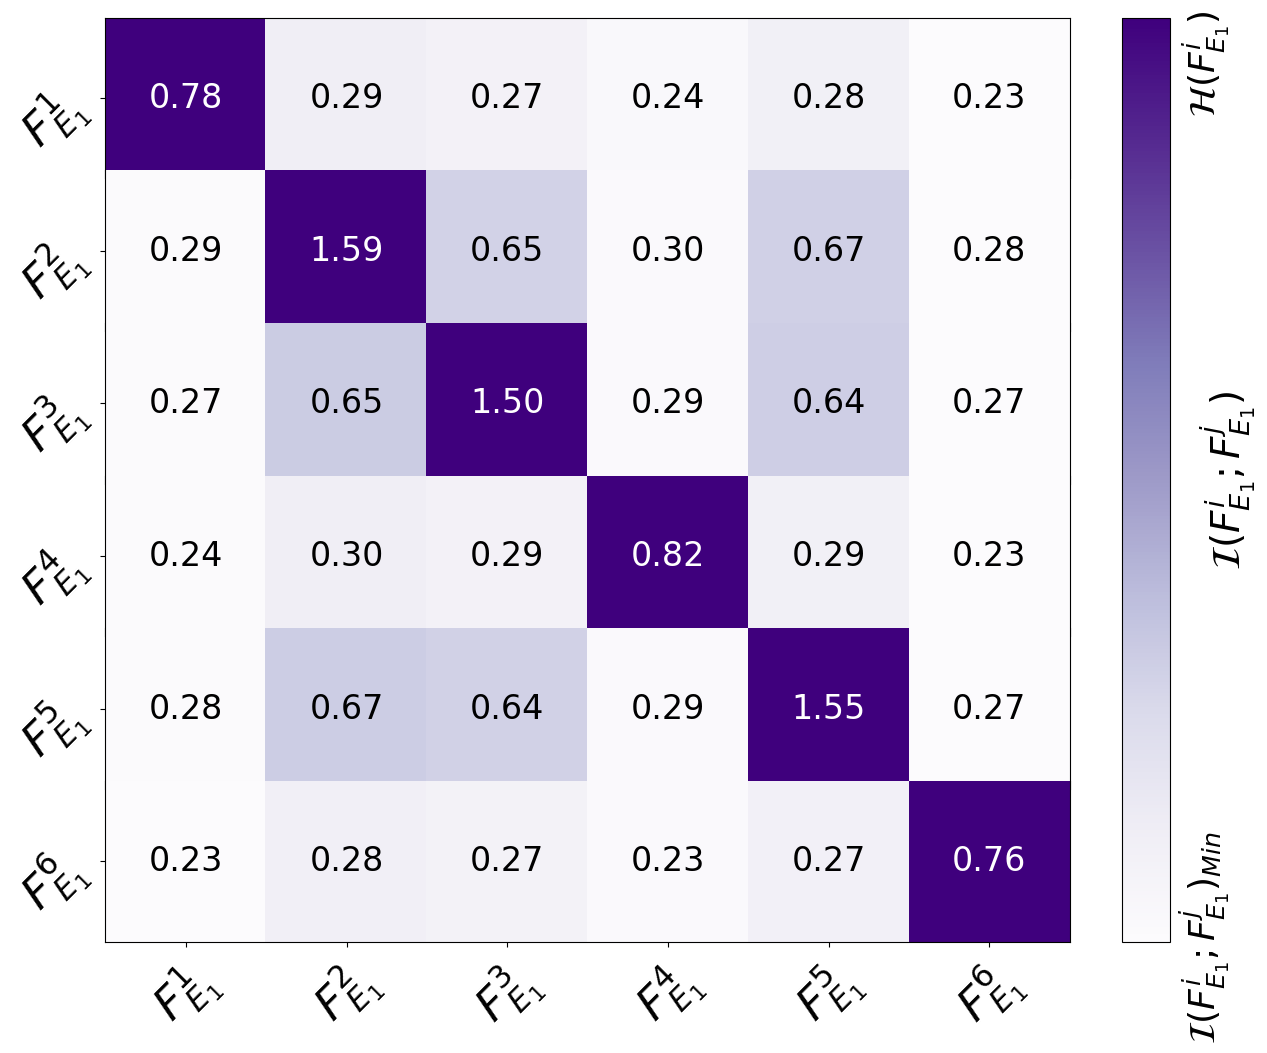

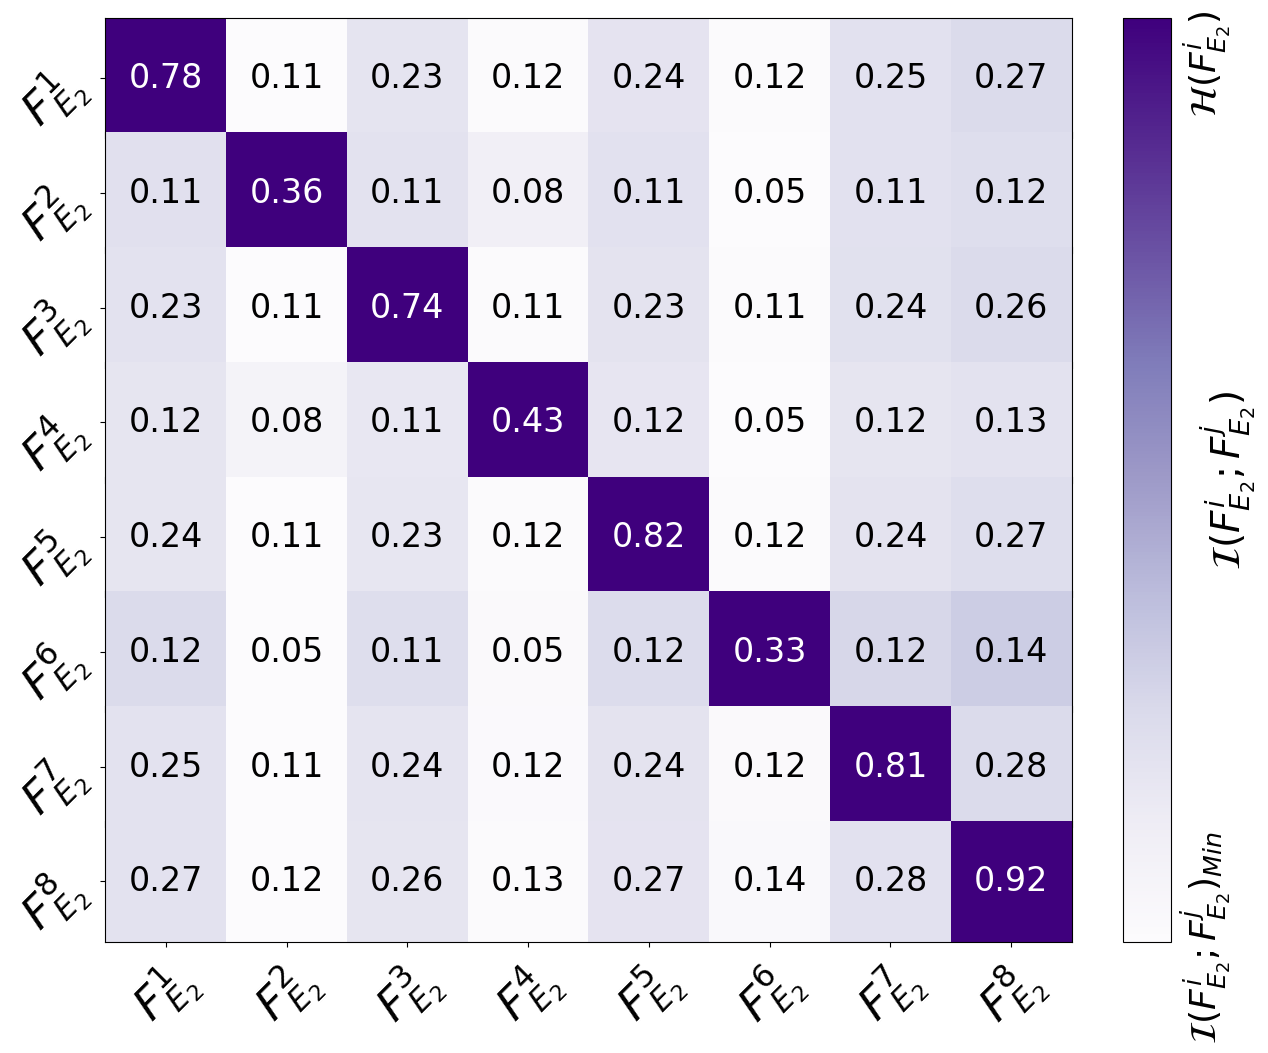

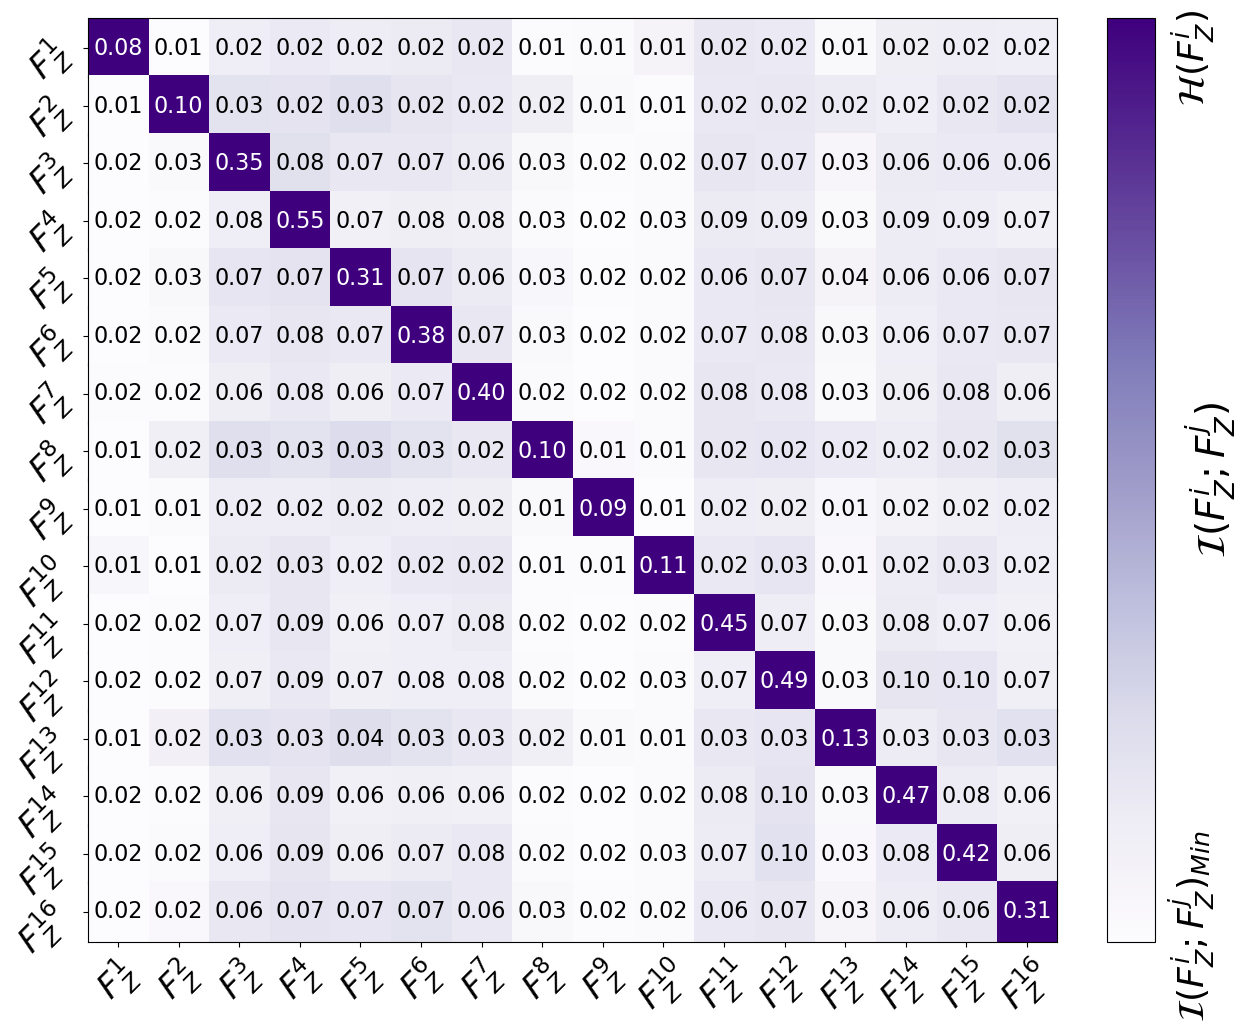

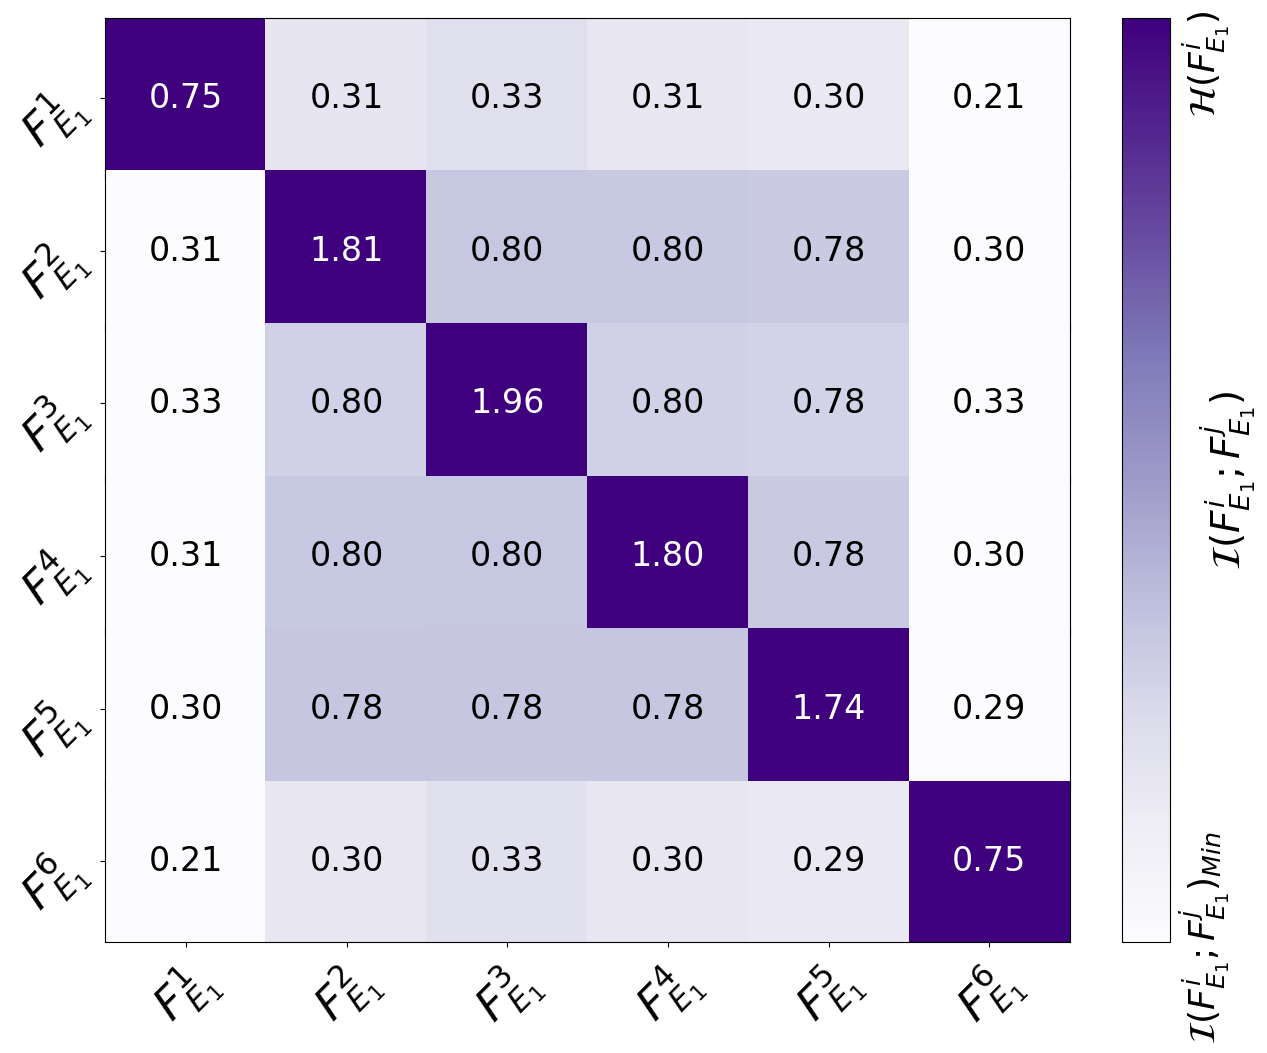

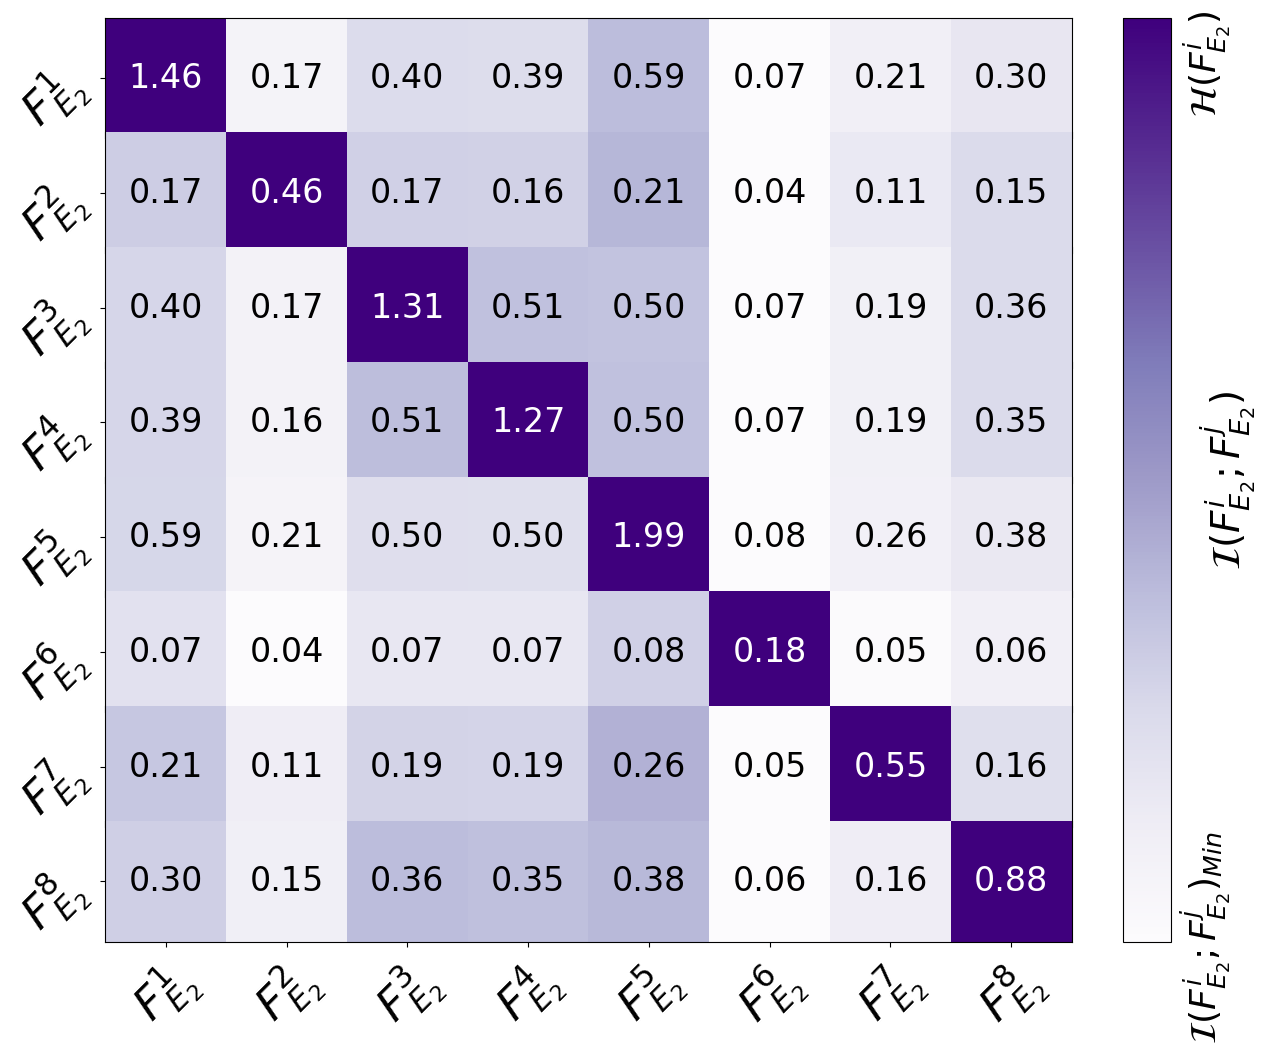

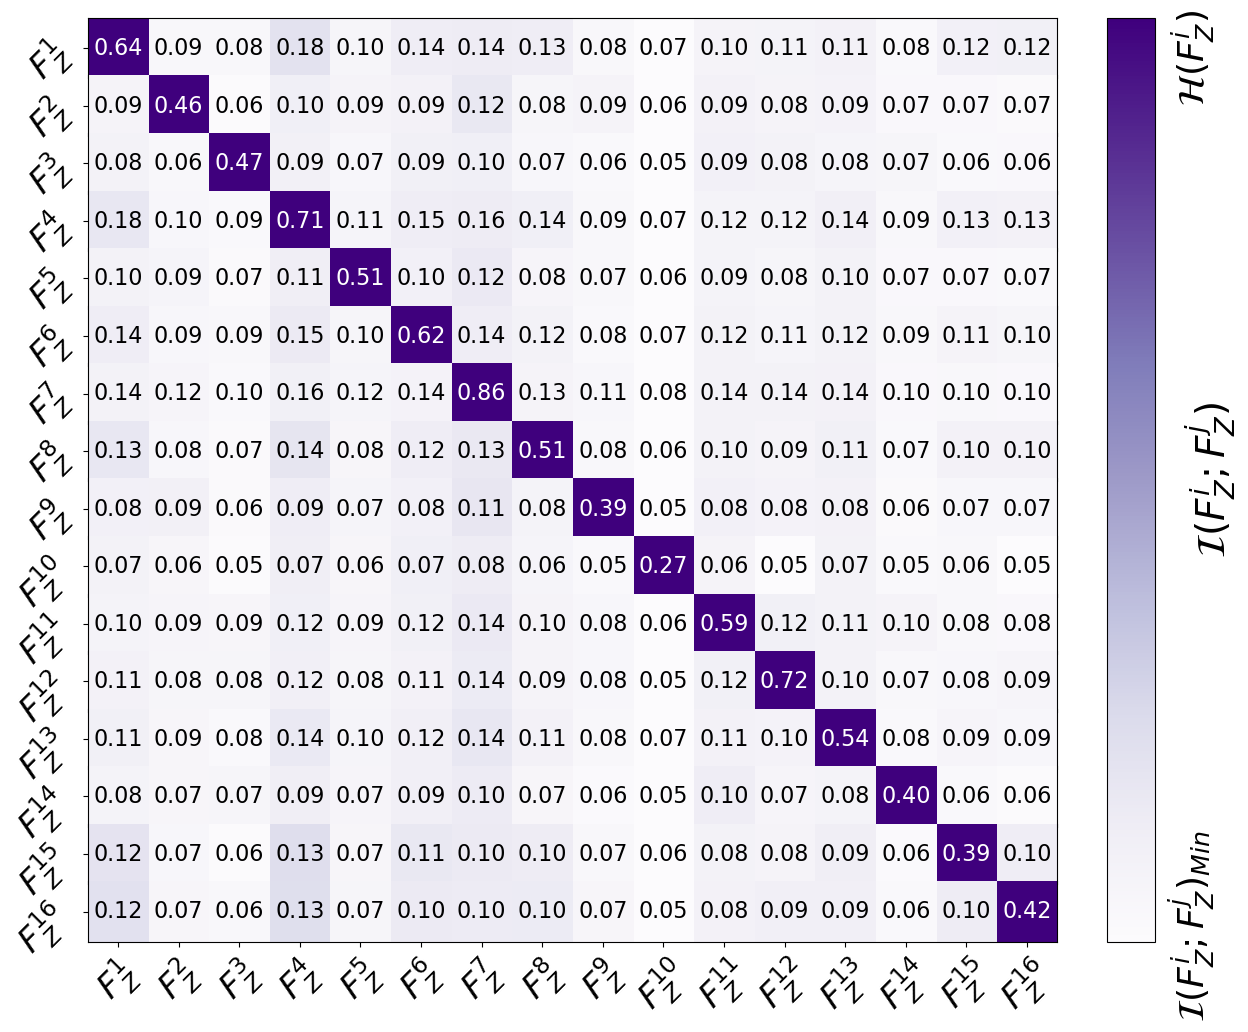

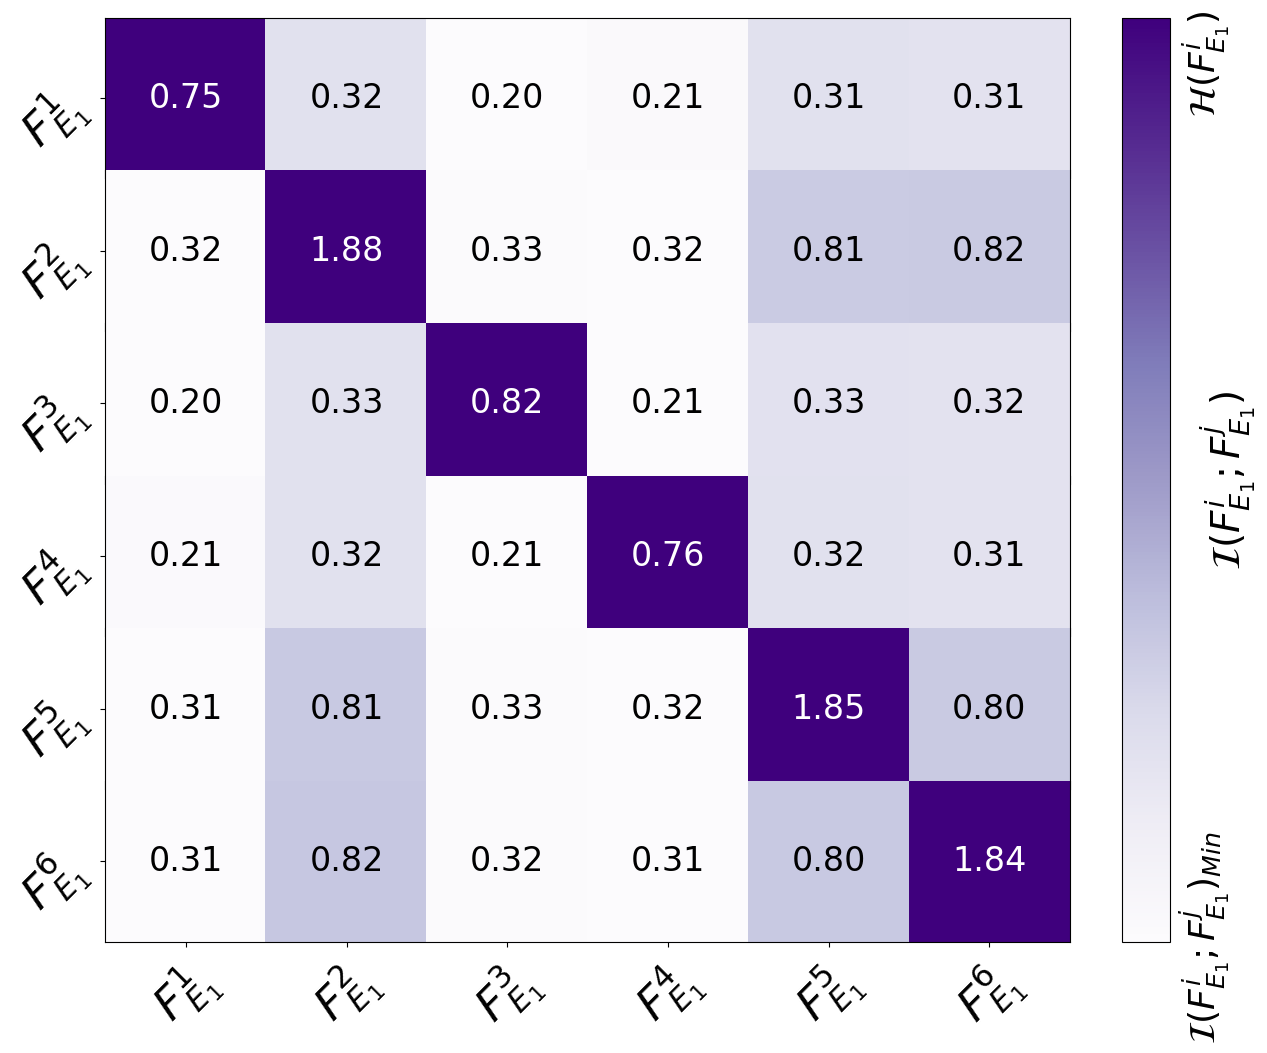

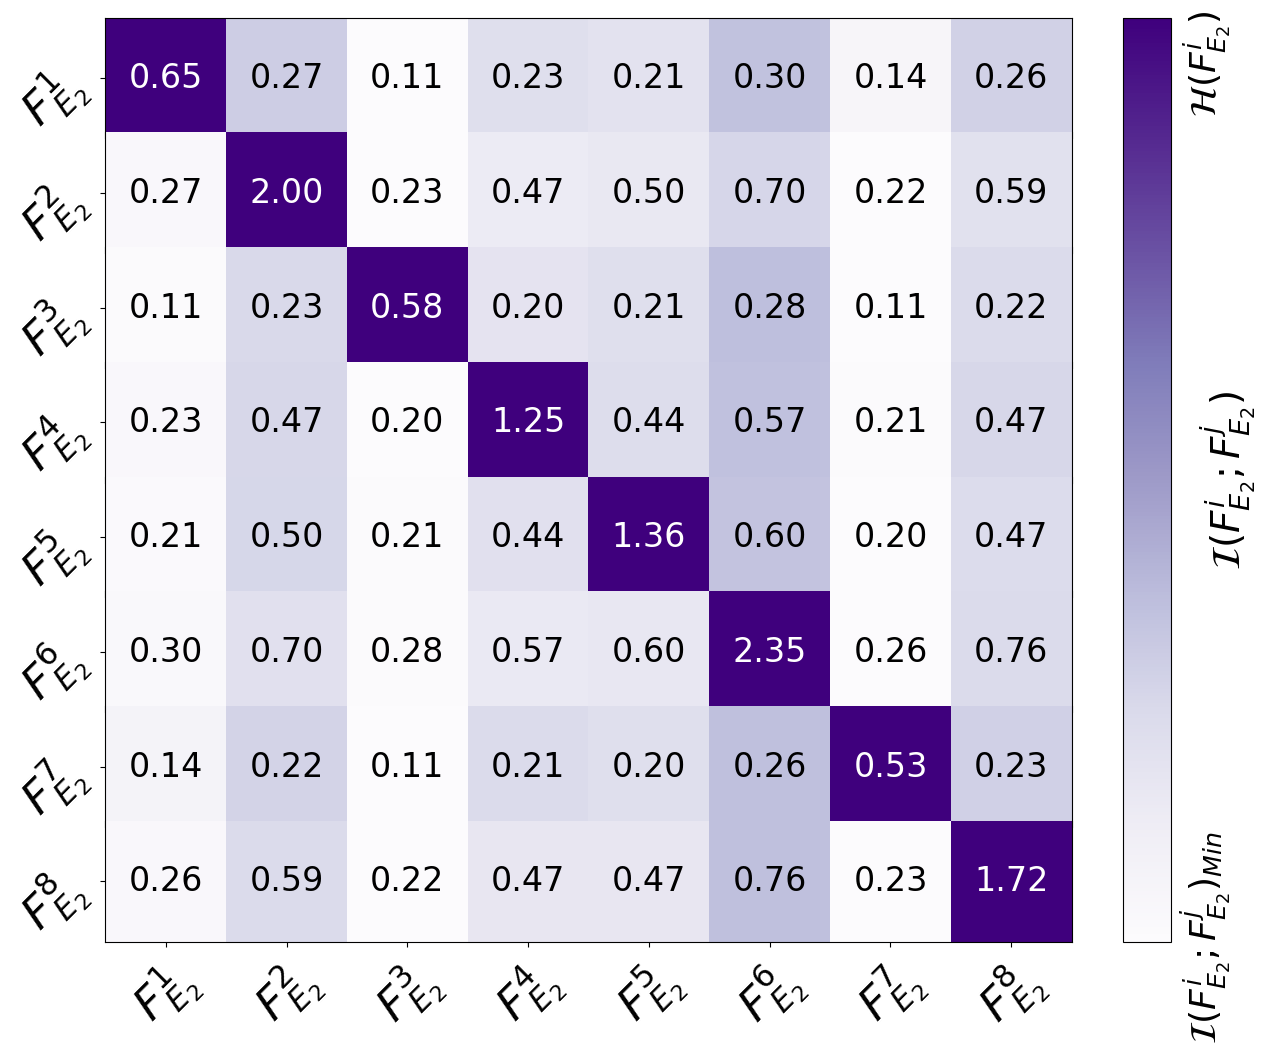

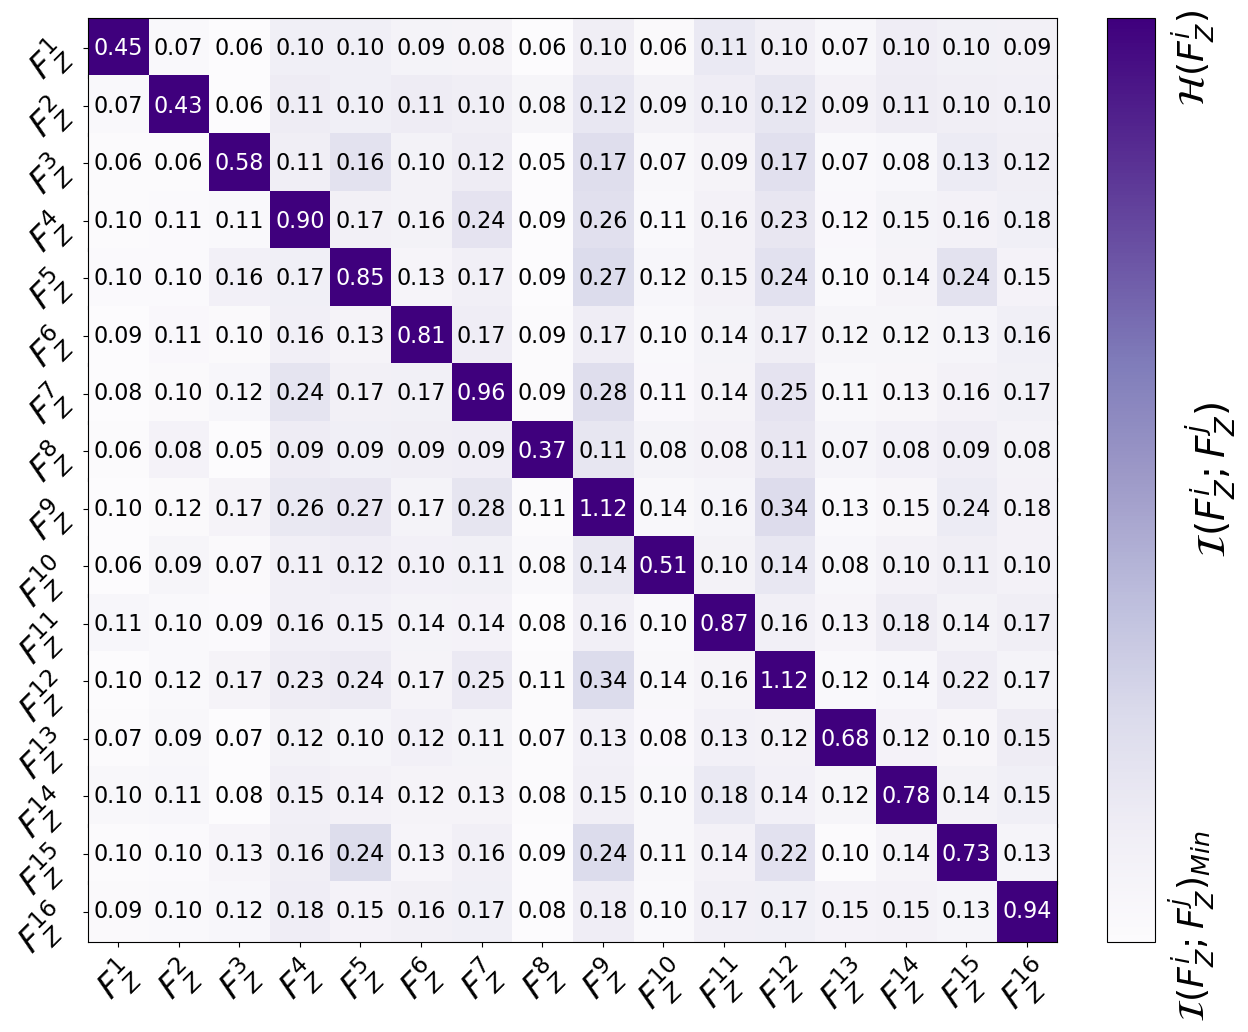

In [128]:
model_name='ae_dropout_p5'
model = SDAE(**ae_dropout_p5)

model_name='ae_dropout_p2'
model = SDAE(**ae_dropout_p2)

model_name='ae_no_dropout'
model = SDAE(**ae_no_dropout)

model_name = ['ae_dropout_p5', 'ae_dropout_p2', 'ae_no_dropout']
model_config = [ae_dropout_p5, ae_dropout_p2, ae_no_dropout]
encode_labels = ['E_1', 'E_2', 'Z']
for i in range(len(model_name)):
    model = SDAE(**model_config[i])
    model.load_state_dict(torch.load('models/{}/AE_FMNIST.pt'.format(model_name[i])))
    model.eval()
    _ = model(val_inputs)

    for layer_idx, layer in enumerate(model.encode):
        df = conv_mi(layer)
        df.to_pickle('../Result/convolutions/{}/FMNIST/{}.pkl'.format(model_name[i], encode_labels[layer_idx]))
        fig = show_convolutional_filters_mi(df, encode_labels[layer_idx])
        fig.savefig('../Result/convolutions/{}/FMNIST/imgs/{}.pdf'.format(model_name[i], encode_labels[layer_idx]), bbox_inches='tight')

Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout2d(p=0.5, inplace=False)
MatrixEstimator(sigma=31.34, requires_optim=True)
Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout2d(p=0.5, inplace=False)
MatrixEstimator(sigma=18.07, requires_optim=True)
Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout2d(p=0.5, inplace=False)
MatrixEstimator(sigma=12.76, requires_optim=True)
Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(

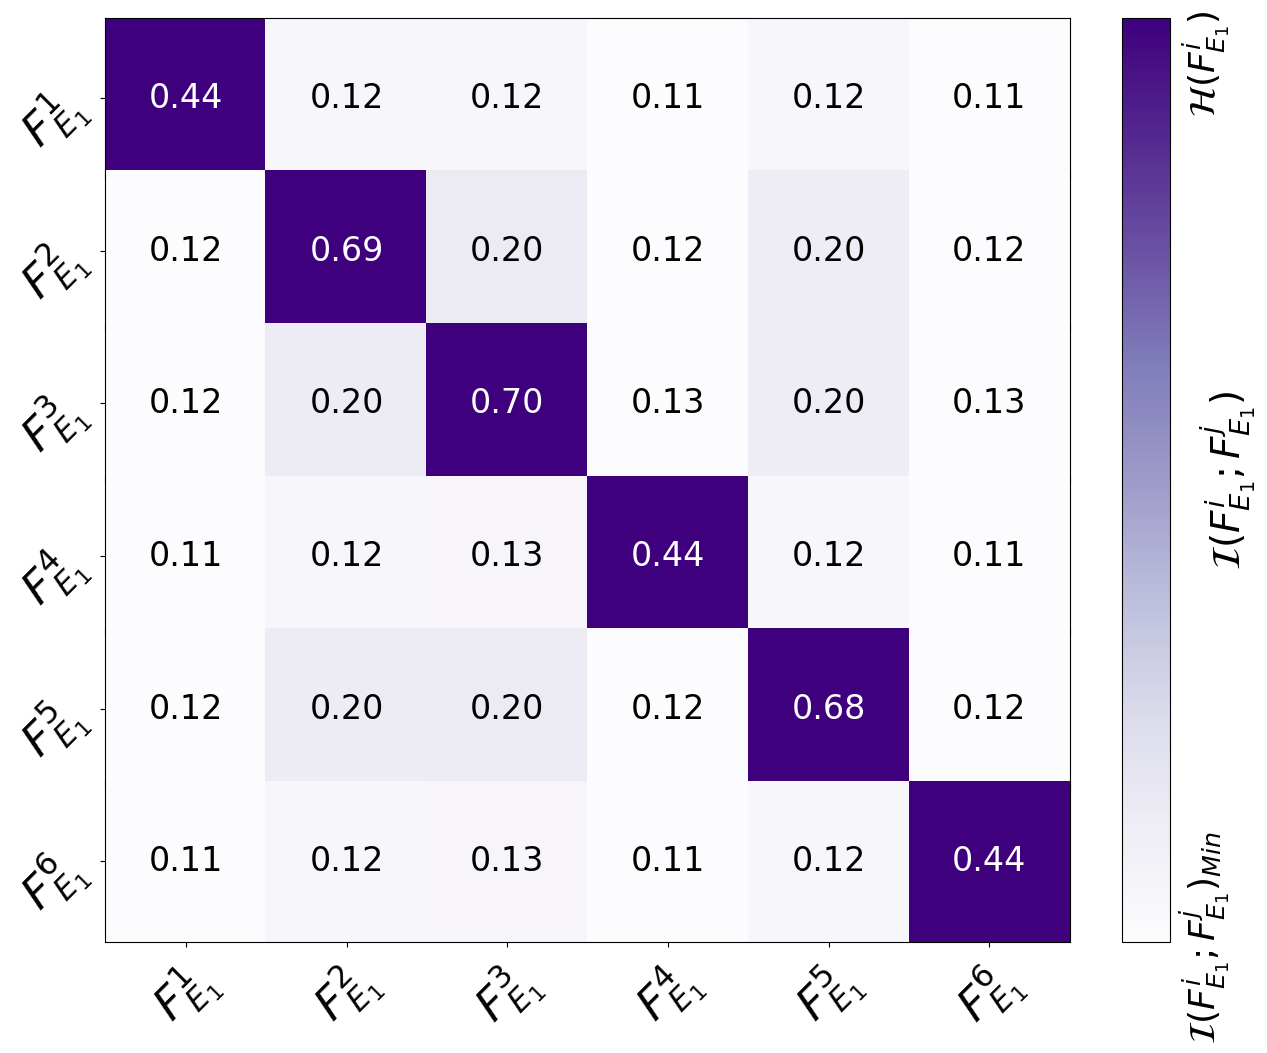

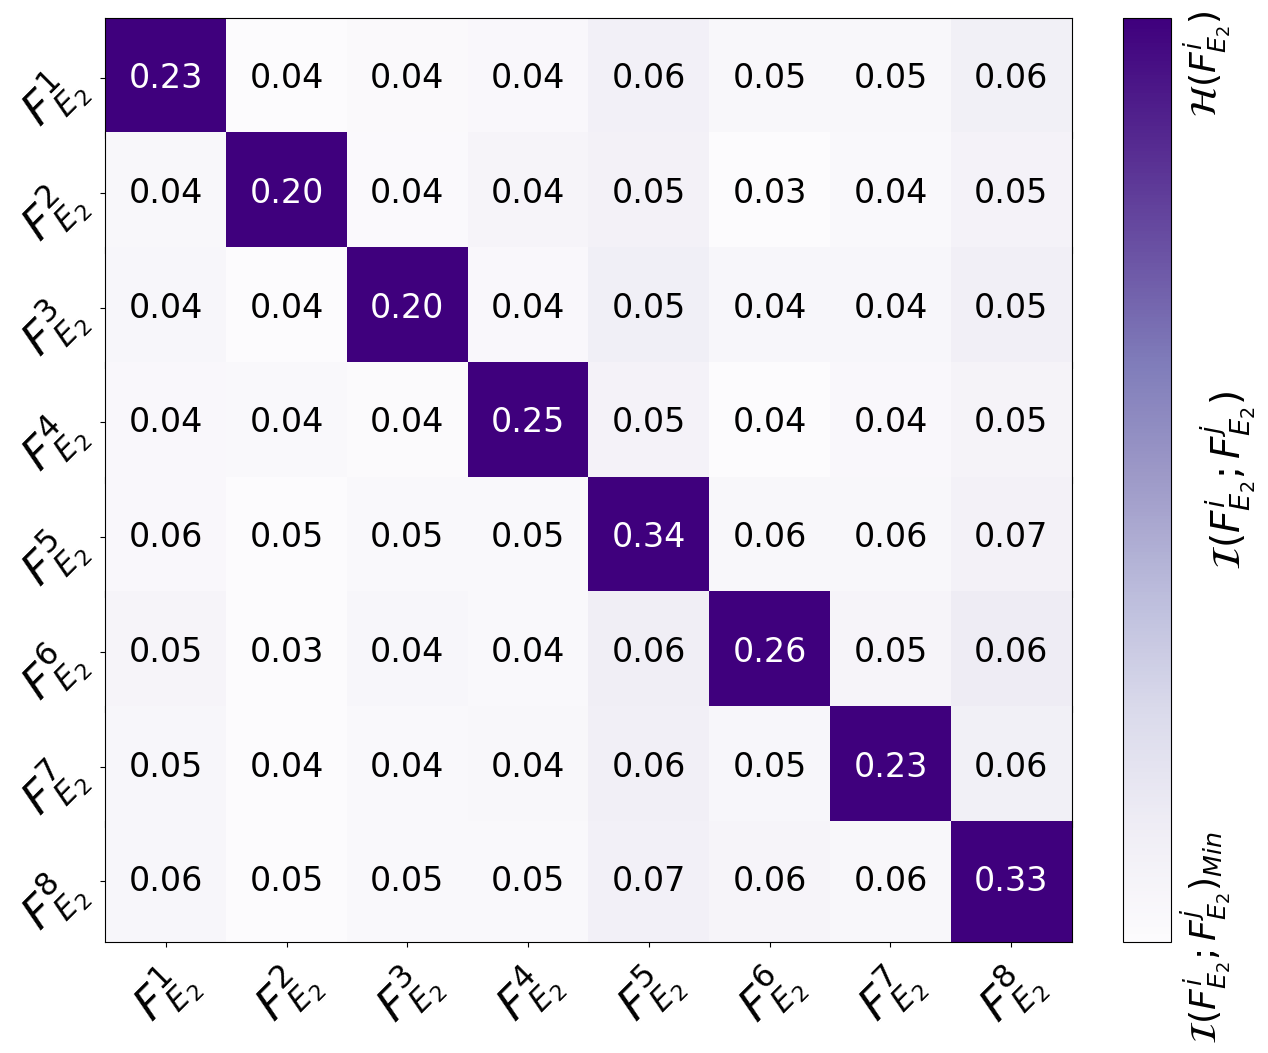

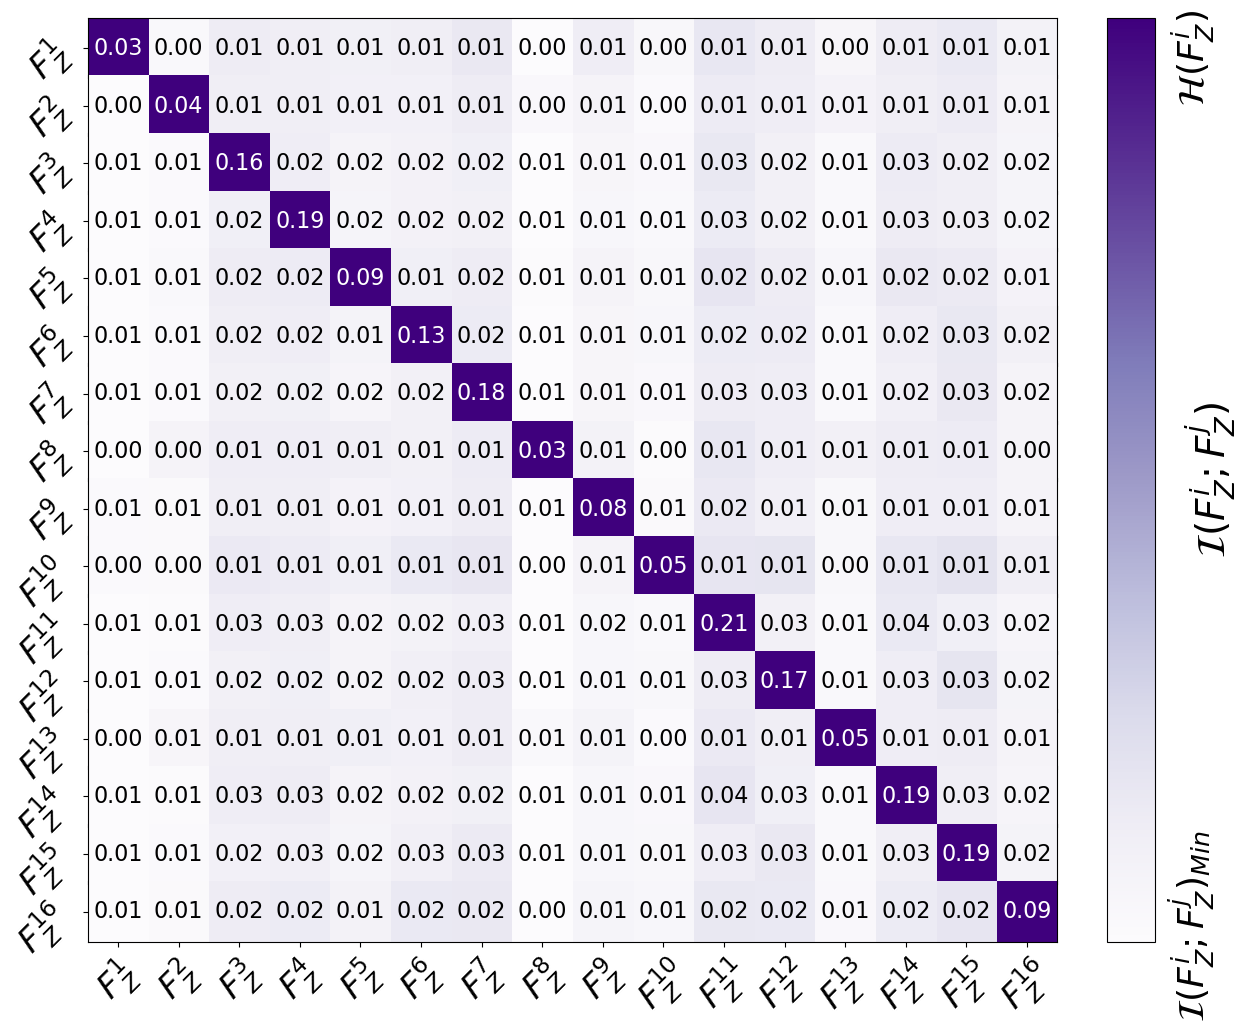

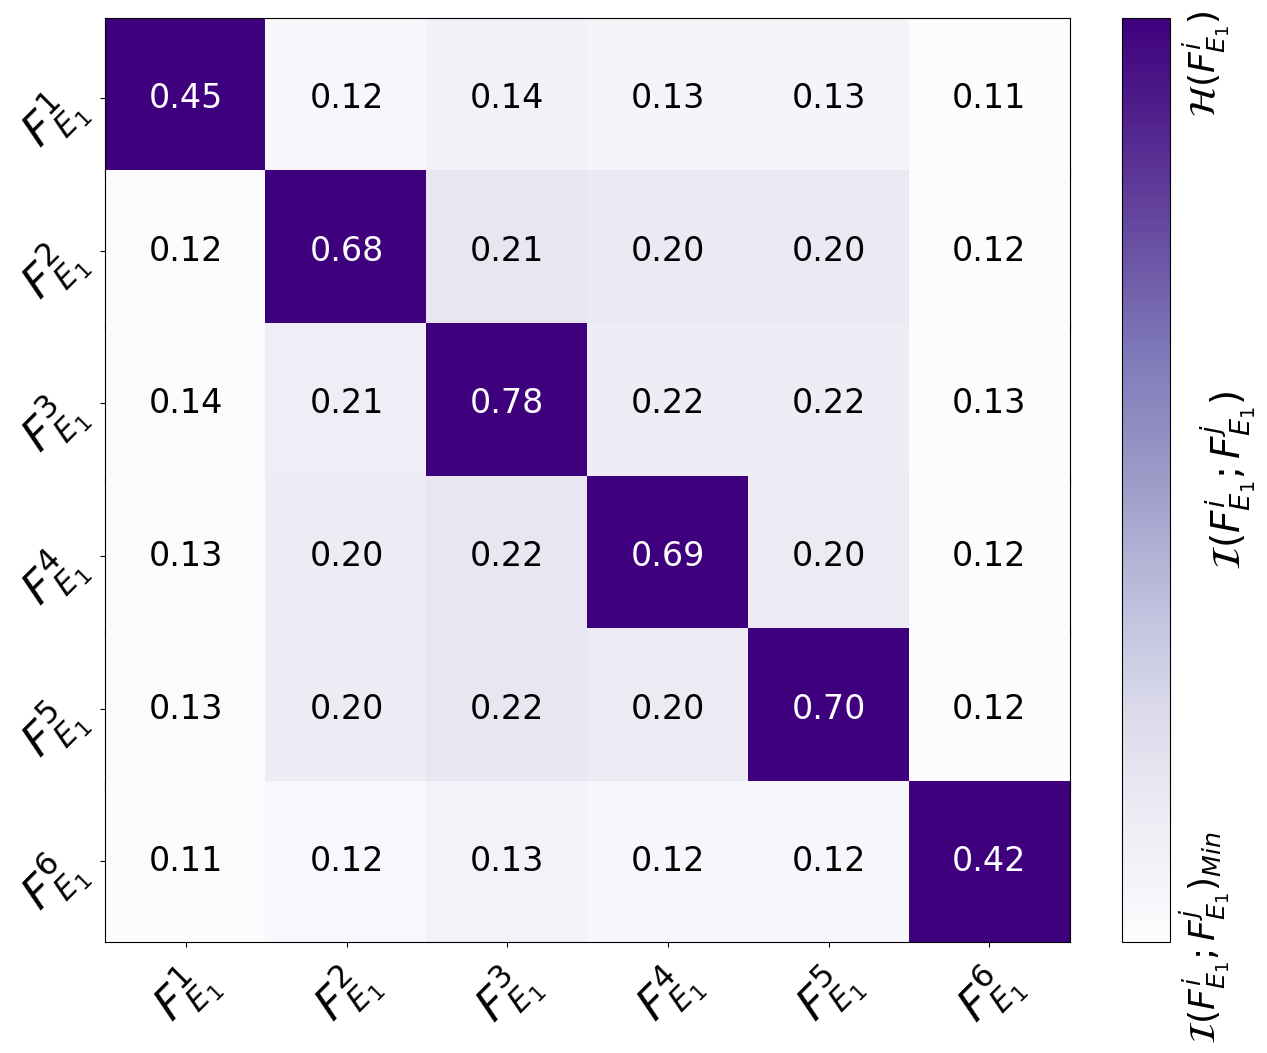

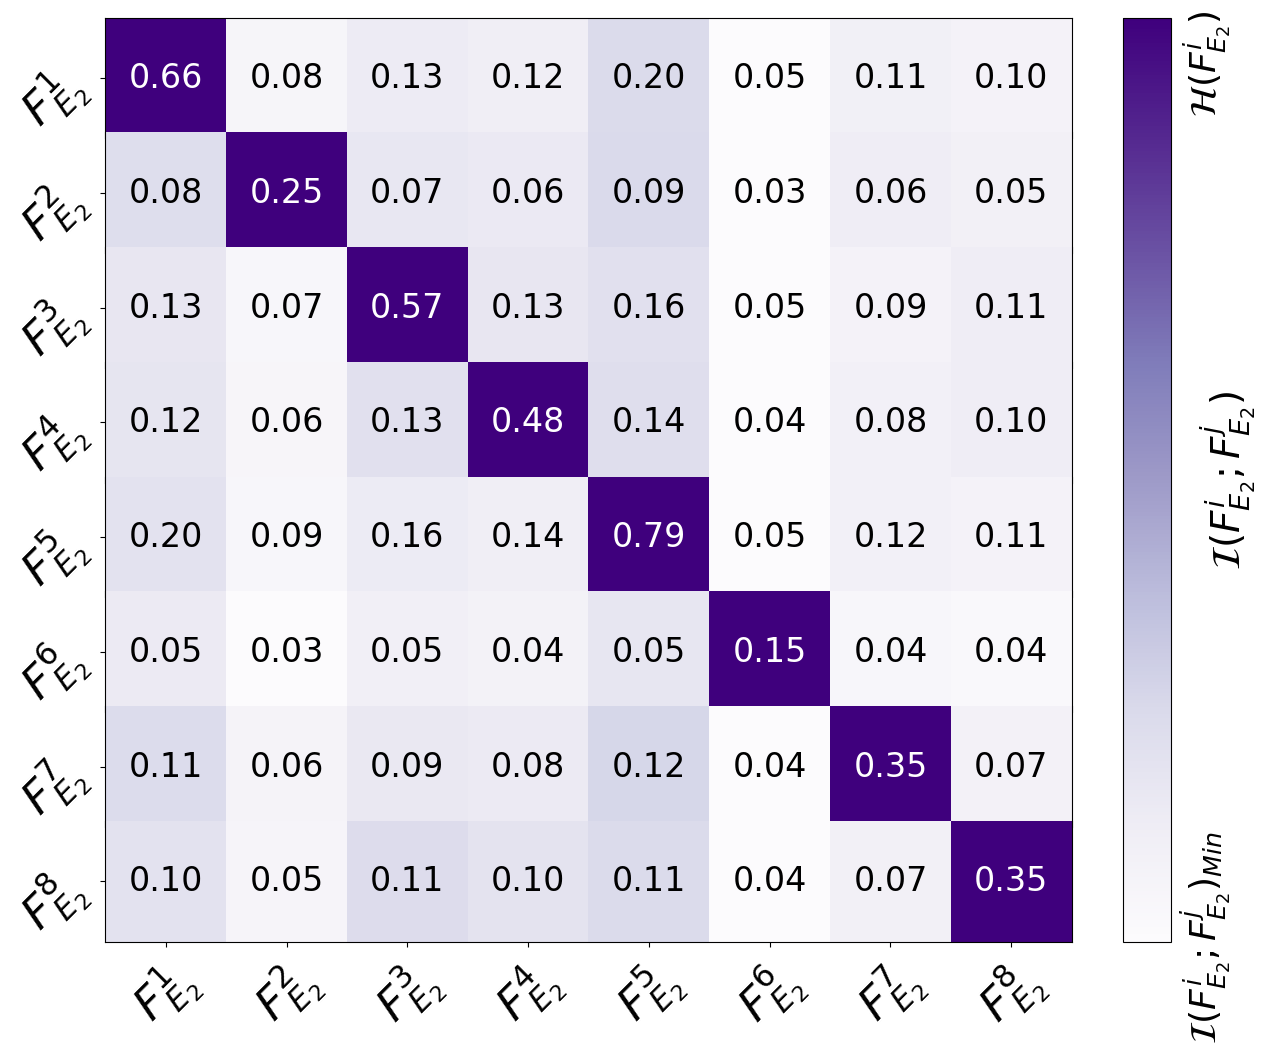

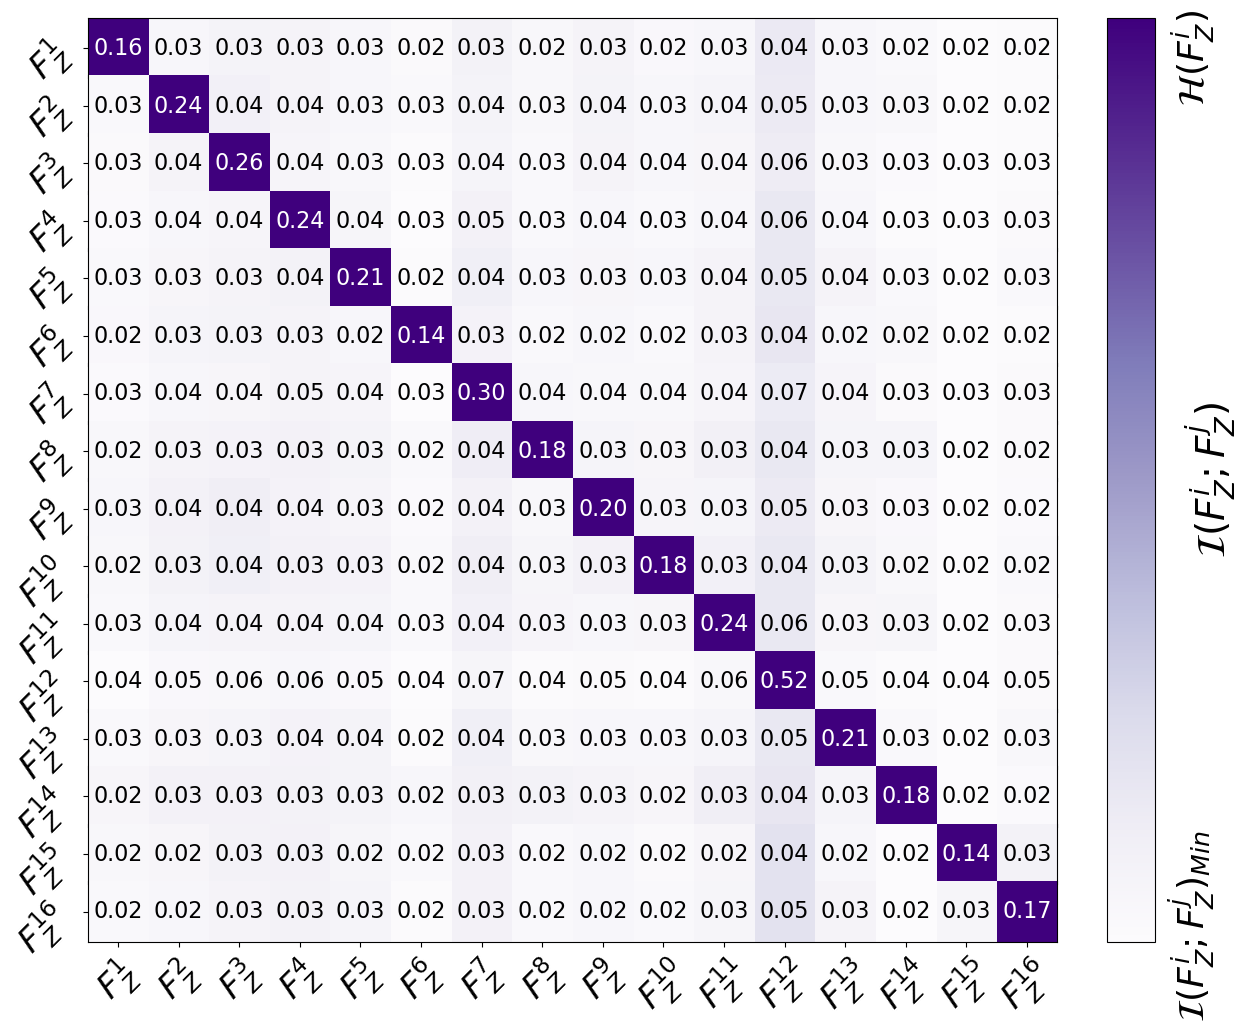

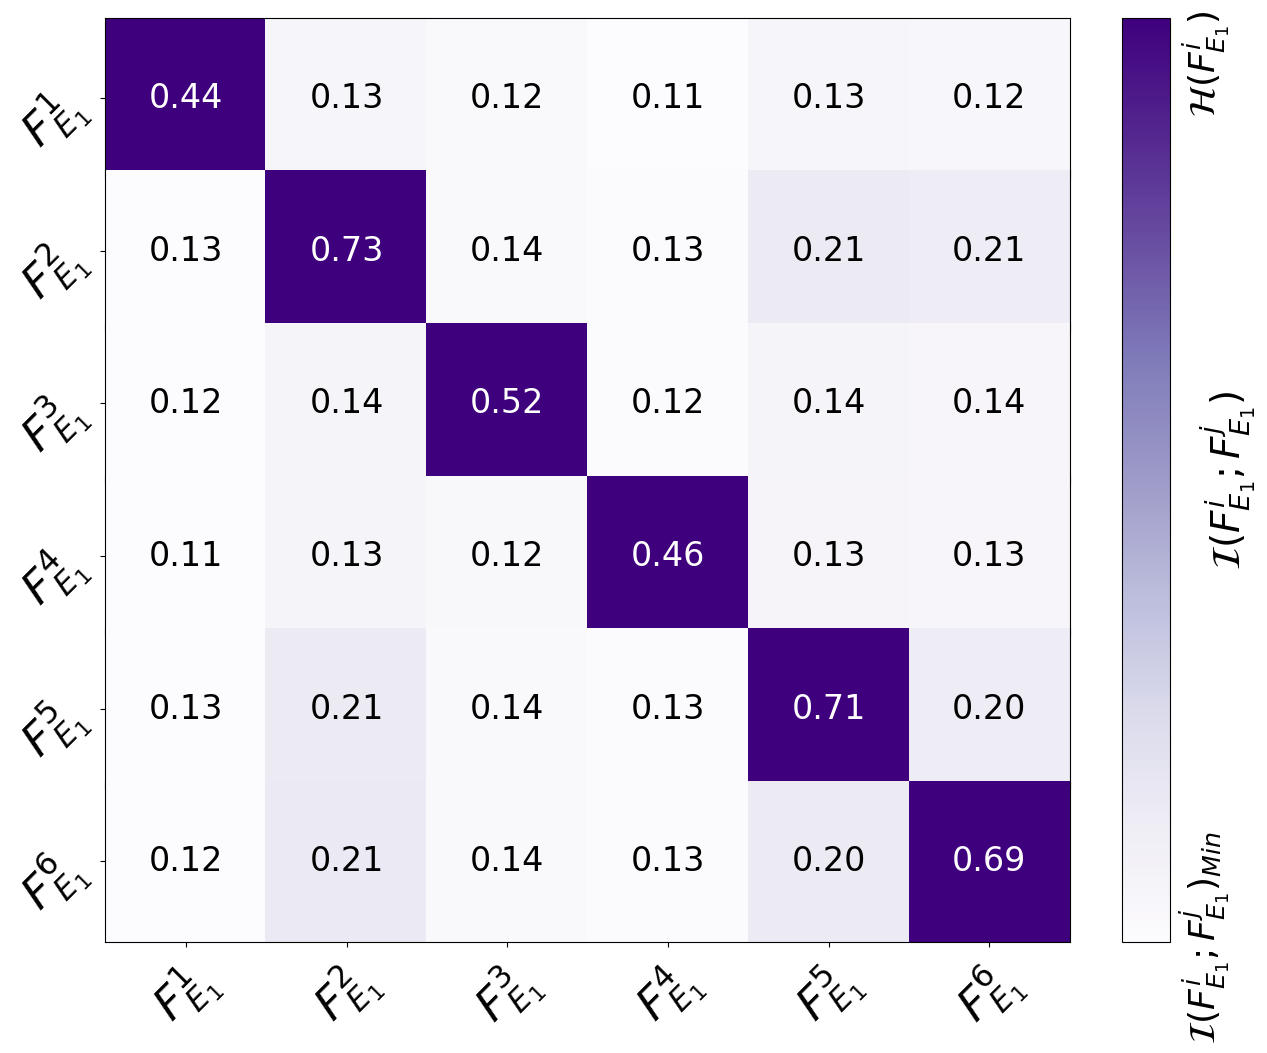

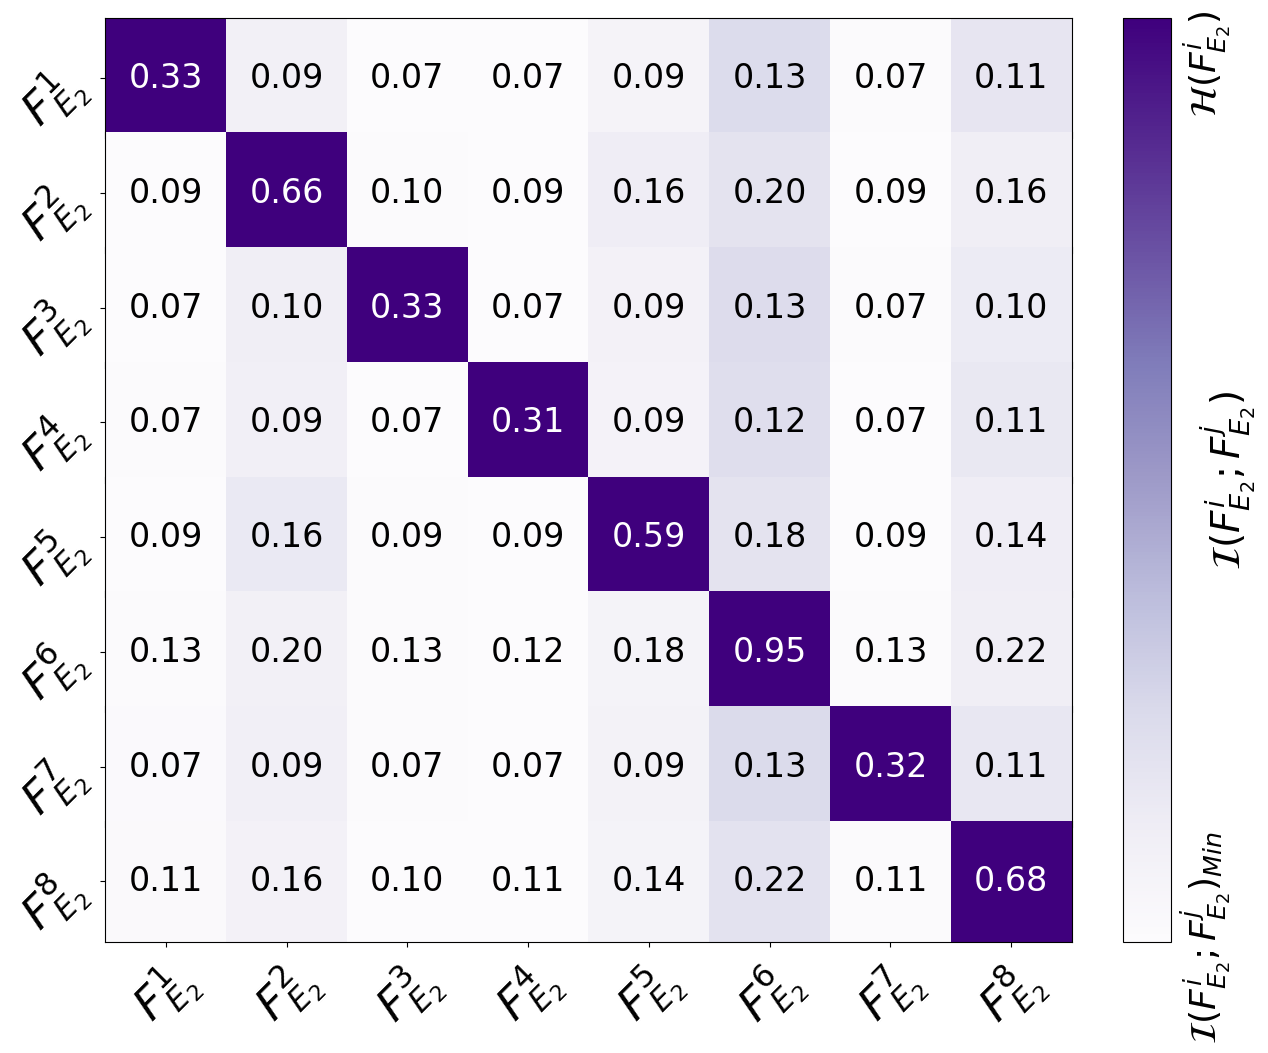

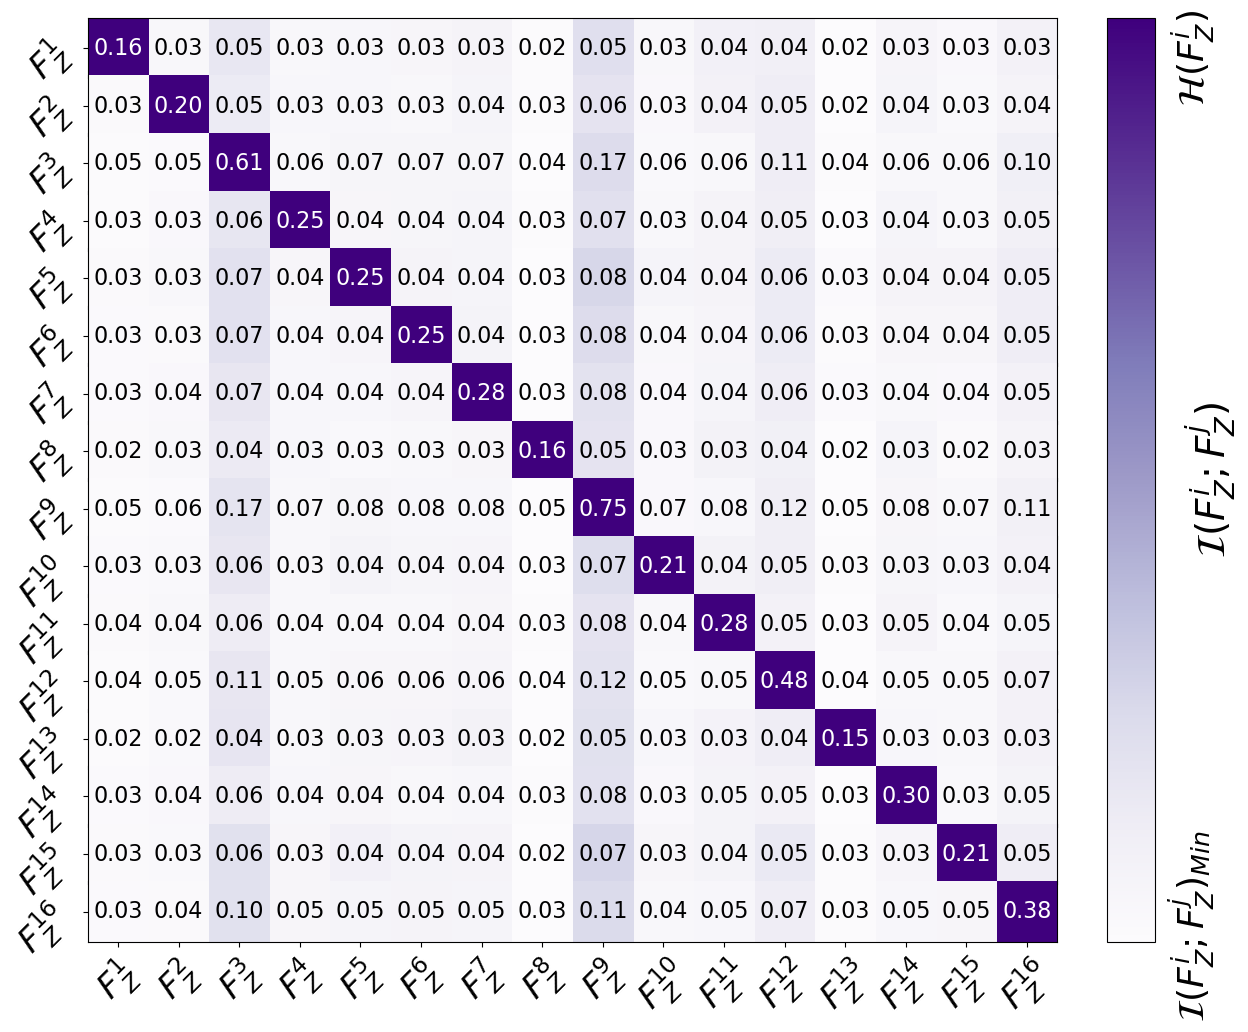

In [142]:
model_name='ae_dropout_p5'
model = SDAE(**ae_dropout_p5)

model_name='ae_dropout_p2'
model = SDAE(**ae_dropout_p2)

model_name='ae_no_dropout'
model = SDAE(**ae_no_dropout)

model_name = ['ae_dropout_p5', 'ae_dropout_p2', 'ae_no_dropout']
model_config = [ae_dropout_p5, ae_dropout_p2, ae_no_dropout]
encode_labels = ['E_1', 'E_2', 'Z']
for i in range(len(model_name)):
    model = SDAE(**model_config[i])
    model.load_state_dict(torch.load('models/{}/AE_DFU.pt'.format(model_name[i])))
    model.eval()
    _ = model(val_inputs)

    for layer_idx, layer in enumerate(model.encode):
        df = conv_mi(layer)
        df.to_pickle('../Result/convolutions/{}/DFU/{}.pkl'.format(model_name[i], encode_labels[layer_idx]))
        fig = show_convolutional_filters_mi(df, encode_labels[layer_idx])
        fig.savefig('../Result/convolutions/{}/DFU/imgs/{}.pdf'.format(model_name[i], encode_labels[layer_idx]), bbox_inches='tight')